
# **Human Detection in Low Light Environments using Thermal Imaging**

#**Project Overview**

This project addresses the challenge of detecting humans in low-light environments using thermal imaging, which captures infrared heat signatures rather than visible light. A publicly available thermal dataset originally in YOLO format was used, with preprocessing steps applied such as resizing, brightness adjustment, and noise filtering. Annotations were converted to COCO format where required for compatibility.

The following object detection models were trained and evaluated on the same dataset:

YOLOv8

1.   YOLOv8
2.   YOLOv8s
3.   Faster R-CNN
4.   RetinaNet


Each model's performance was assessed using standard object detection metrics:



1.   mAP@0.5:0.95
2.   Precision
3.   mAP@0.5
4.   Recall

The goal was to identify the most effective architecture for accurate human detection in thermal images, enabling robust solutions for surveillance and safety in low-light or night-time conditions.

In [ ]:
#INSTALLATIONS

!pip install -q kagglehub torchmetrics timm effdet ultralytics torchvision
!pip install -q torchmetrics
!pip install -q kagglehub
!pip install torch torchvision torchmetrics pycocotools matplotlib tqdm




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:

In [ ]:
#IMPORT LIBRARIES

import os, json, torch, zipfile
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoDetection
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights
import kagglehub



In [ ]:
from google.colab import files
files.upload()  # kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"khawlahalhbaeeb","key":"911dc5d3f831115be5d8886fb5cd5369"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d sikdermdsaiful/thermal-images-for-human-detection -p /content/data


Dataset URL: https://www.kaggle.com/datasets/sikdermdsaiful/thermal-images-for-human-detection
License(s): CC0-1.0


In [ ]:
import zipfile
zip_path = "/content/data/thermal-images-for-human-detection.zip"
extract_path = "/content/data/thermal_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/data/thermal_dataset


In [ ]:
def download_and_extract():
    os.makedirs("data", exist_ok=True)
    os.system("kaggle datasets download -d sikdermdsaiful/thermal-images-for-human-detection -p data")
    with zipfile.ZipFile("data/thermal-images-for-human-detection.zip", 'r') as zip_ref:
        zip_ref.extractall("data/thermal_dataset")
    print("Downloaded and extracted.")

def preprocess_image(img_path, save_dir, resize=(640, 512)):
    img = Image.open(img_path).convert("RGB").resize(resize)
    img = ImageEnhance.Brightness(img).enhance(0.7)
    img = img.filter(ImageFilter.GaussianBlur(radius=0.5))
    os.makedirs(save_dir, exist_ok=True)
    out_path = os.path.join(save_dir, os.path.basename(img_path))
    img.save(out_path)
    return out_path

def yolo_to_coco(img_dir, label_dir, save_img_dir, output_json, class_name="person", resize=(640,512)):
    categories = [{"id": 1, "name": class_name}]
    images, annotations = [], []
    img_id, ann_id = 1, 1

    for img_file in sorted(os.listdir(img_dir)):
        if not img_file.endswith(('.jpg', '.png')): continue
        img_path = os.path.join(img_dir, img_file)
        lbl_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + ".txt")
        new_path = preprocess_image(img_path, save_img_dir, resize)
        with Image.open(new_path) as img:
            w, h = img.size
        images.append({"id": img_id, "file_name": os.path.basename(new_path), "width": w, "height": h})
        if os.path.exists(lbl_path):
            with open(lbl_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5: continue
                    cls, xc, yc, bw, bh = map(float, parts)
                    x, y = (xc - bw/2)*w, (yc - bh/2)*h
                    annotations.append({
                        "id": ann_id, "image_id": img_id, "category_id": 1,
                        "bbox": [x, y, bw*w, bh*h], "area": bw*w*bh*h, "iscrowd": 0
                    })
                    ann_id += 1
        img_id += 1

    os.makedirs(os.path.dirname(output_json), exist_ok=True)
    with open(output_json, 'w') as f:
        json.dump({"images": images, "annotations": annotations, "categories": categories}, f, indent=4)
    print(f"COCO saved: {output_json}")

def remove_empty_images(coco_json_path, image_dir, output_json_path):
    with open(coco_json_path, 'r') as f:
        coco = json.load(f)
    valid_ids = {ann['image_id'] for ann in coco['annotations']}
    cleaned_images = [img for img in coco['images'] if img['id'] in valid_ids]
    for img in coco['images']:
        if img['id'] not in valid_ids:
            try:
                os.remove(os.path.join(image_dir, img['file_name']))
            except: pass
    cleaned_coco = {
        "images": cleaned_images,
        "annotations": [a for a in coco['annotations'] if a['image_id'] in valid_ids],
        "categories": coco['categories']
    }
    with open(output_json_path, 'w') as f:
        json.dump(cleaned_coco, f, indent=4)
    print(f"Cleaned + saved: {output_json_path}")

In [ ]:
def run_all():
    download_and_extract()
    base = "data/thermal_dataset/dataset"
    yolo_to_coco(f"{base}/train/images", f"{base}/train/labels", "preprocessed_data/train/images", "preprocessed_data/annotations/train_coco.json")
    yolo_to_coco(f"{base}/test/images", f"{base}/test/labels", "preprocessed_data/test/images", "preprocessed_data/annotations/test_coco.json")
    remove_empty_images("preprocessed_data/annotations/train_coco.json", "preprocessed_data/train/images", "preprocessed_data/annotations/train_coco_cleaned.json")
    remove_empty_images("preprocessed_data/annotations/test_coco.json", "preprocessed_data/test/images", "preprocessed_data/annotations/test_coco_cleaned.json")

run_all()

Downloaded and extracted.
COCO saved: preprocessed_data/annotations/train_coco.json
COCO saved: preprocessed_data/annotations/test_coco.json
Cleaned + saved: preprocessed_data/annotations/train_coco_cleaned.json
Cleaned + saved: preprocessed_data/annotations/test_coco_cleaned.json


In [ ]:
def coco_to_yolo(coco_json_path, output_label_dir):
    with open(coco_json_path) as f:
        coco = json.load(f)

    os.makedirs(output_label_dir, exist_ok=True)

    # map image_id → image metadata
    image_map = {img["id"]: img for img in coco["images"]}
    labels = {img["id"]: [] for img in coco["images"]}

    for ann in coco["annotations"]:
        img_id = ann["image_id"]
        img = image_map[img_id]
        x, y, w, h = ann["bbox"]

        xc = (x + w / 2) / img["width"]
        yc = (y + h / 2) / img["height"]
        bw = w / img["width"]
        bh = h / img["height"]

        labels[img_id].append(f"0 {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}")

    for img_id, lines in labels.items():
        file_name = os.path.splitext(image_map[img_id]["file_name"])[0] + ".txt"
        file_path = os.path.join(output_label_dir, file_name)
        with open(file_path, "w") as f:
            f.write("\n".join(lines))

    print(f"Done: saved {len(labels)} label files to {output_label_dir}")


coco_to_yolo(
    "/content/preprocessed_data/annotations/train_coco_cleaned.json",
    "/content/preprocessed_data/train/labels"
)

coco_to_yolo(
    "/content/preprocessed_data/annotations/test_coco_cleaned.json",
    "/content/preprocessed_data/test/labels"
)

Done: saved 12023 label files to /content/preprocessed_data/train/labels
Done: saved 3463 label files to /content/preprocessed_data/test/labels


In [ ]:

image_dir = "/content/preprocessed_data/train/images"
label_dir = "/content/preprocessed_data/train/labels"


with open("/content/preprocessed_data/annotations/train_coco_cleaned.json") as f:
    data = json.load(f)
image_names = [os.path.splitext(img["file_name"])[0] for img in data["images"]]


missing_txt = []
for name in image_names:
    label_path = os.path.join(label_dir, name + ".txt")
    if not os.path.exists(label_path):
        missing_txt.append(name)


print(f"✅ Total images expected: {len(image_names)}")
print(f"✅ Total .txt labels found: {len(image_names) - len(missing_txt)}")
print(f"❌ Missing .txt labels: {len(missing_txt)}")


if missing_txt:
    print("⚠️ First 5 missing examples:", missing_txt[:5])


✅ Total images expected: 12023
✅ Total .txt labels found: 12023
❌ Missing .txt labels: 0


## YOLOv8n and YOLOv8s

In [ ]:
from ultralytics import YOLO

# Prepare data.yaml for training
yaml_content = """
path: /content/preprocessed_data
train: train
val: test
names:
  0: person
"""
with open("data.yaml", "w") as f:
    f.write(yaml_content.strip())

# Load YOLOv8n and YOLOv8s models
yolo_n = YOLO("yolov8n.pt")
yolo_s = YOLO("yolov8s.pt")

# Train YOLOv8n
yolo_n.train(data="data.yaml", epochs=10, imgsz=640, batch=16, device="cuda", project="runs/yolov8_results", name="yolov8n")
# Train YOLOv8s
yolo_s.train(data="data.yaml", epochs=10, imgsz=640, batch=16, device="cuda", project="runs/yolov8_results", name="yolov8s")



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 325MB/s]


100%|██████████| 21.5M/21.5M [00:00<00:00, 273MB/s]


Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=runs/yolov8_results, name=yolov8n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True

100%|██████████| 755k/755k [00:00<00:00, 103MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 315MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1190.1±389.5 MB/s, size: 31.3 KB)


train: Scanning /content/preprocessed_data/train/labels... 12023 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12023/12023 [00:07<00:00, 1562.76it/s]


train: New cache created: /content/preprocessed_data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 862.6±422.9 MB/s, size: 24.4 KB)


val: Scanning /content/preprocessed_data/test/labels... 3463 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3463/3463 [00:02<00:00, 1394.30it/s]

val: New cache created: /content/preprocessed_data/test/labels.cache


Plotting labels to runs/yolov8_results/yolov8n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/yolov8_results/yolov8n
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.16G      1.475      1.286      1.241         27        640: 100%|██████████| 752/752 [01:10<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.39it/s]


                   all       3463       8302      0.897      0.792       0.88      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.41G      1.441     0.8584      1.245         15        640: 100%|██████████| 752/752 [01:05<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:13<00:00,  7.94it/s]


                   all       3463       8302      0.856      0.738      0.836      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.43G      1.412     0.7916       1.23         15        640: 100%|██████████| 752/752 [01:04<00:00, 11.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:13<00:00,  7.92it/s]


                   all       3463       8302      0.935      0.863      0.932      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.45G       1.37     0.7417       1.21         18        640: 100%|██████████| 752/752 [01:03<00:00, 11.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:13<00:00,  8.07it/s]


                   all       3463       8302      0.927      0.822      0.907      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.46G      1.339     0.6928      1.195         13        640: 100%|██████████| 752/752 [01:03<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:13<00:00,  7.97it/s]


                   all       3463       8302      0.952       0.86      0.941      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.48G      1.303     0.6576      1.177         17        640: 100%|██████████| 752/752 [01:03<00:00, 11.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.75it/s]


                   all       3463       8302      0.903      0.816       0.92      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.49G      1.279     0.6263      1.161         21        640: 100%|██████████| 752/752 [01:03<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:13<00:00,  7.99it/s]


                   all       3463       8302      0.909      0.854      0.931      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.51G      1.255     0.6029      1.147         22        640: 100%|██████████| 752/752 [01:02<00:00, 11.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:13<00:00,  7.97it/s]


                   all       3463       8302      0.946      0.873      0.942      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.53G      1.223     0.5766      1.131          9        640: 100%|██████████| 752/752 [01:03<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:13<00:00,  7.96it/s]


                   all       3463       8302      0.951      0.878      0.946      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.54G      1.203     0.5523      1.118         27        640: 100%|██████████| 752/752 [01:03<00:00, 11.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:13<00:00,  8.00it/s]


                   all       3463       8302      0.964      0.875      0.951      0.643

10 epochs completed in 0.218 hours.
Optimizer stripped from runs/yolov8_results/yolov8n/weights/last.pt, 6.2MB
Optimizer stripped from runs/yolov8_results/yolov8n/weights/best.pt, 6.2MB

Validating runs/yolov8_results/yolov8n/weights/best.pt...
Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:15<00:00,  6.83it/s]


                   all       3463       8302      0.964      0.876      0.951      0.643
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/yolov8_results/yolov8n
Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=runs/yolov8_results, name=yolov8s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fa

train: Scanning /content/preprocessed_data/train/labels.cache... 12023 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12023/12023 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 571.1±238.3 MB/s, size: 24.4 KB)


val: Scanning /content/preprocessed_data/test/labels.cache... 3463 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3463/3463 [00:00<?, ?it/s]


Plotting labels to runs/yolov8_results/yolov8s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/yolov8_results/yolov8s
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.76G      1.469      1.026      1.265         27        640: 100%|██████████| 752/752 [01:15<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.41it/s]


                   all       3463       8302      0.885      0.748      0.863       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      4.38G      1.443     0.8273      1.261         15        640: 100%|██████████| 752/752 [01:09<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.51it/s]

                   all       3463       8302       0.91      0.803      0.882      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      4.39G      1.409     0.7799      1.242         15        640: 100%|██████████| 752/752 [01:07<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.49it/s]


                   all       3463       8302      0.931      0.843      0.925      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.39G      1.365     0.7297       1.22         18        640: 100%|██████████| 752/752 [01:06<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.47it/s]


                   all       3463       8302      0.944      0.851      0.929      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      4.39G      1.329     0.6748      1.198         13        640: 100%|██████████| 752/752 [01:07<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.52it/s]


                   all       3463       8302      0.945      0.863      0.938      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10       4.4G      1.287     0.6393      1.175         17        640: 100%|██████████| 752/752 [01:06<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.50it/s]


                   all       3463       8302      0.942      0.865      0.939      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.42G       1.26     0.6097      1.159         21        640: 100%|██████████| 752/752 [01:06<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.55it/s]


                   all       3463       8302      0.947      0.879      0.946       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.42G      1.239     0.5837      1.148         22        640: 100%|██████████| 752/752 [01:06<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.48it/s]


                   all       3463       8302      0.956      0.867      0.939      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      4.42G      1.203     0.5555      1.128          9        640: 100%|██████████| 752/752 [01:07<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.64it/s]


                   all       3463       8302      0.956      0.885      0.946      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      4.42G      1.183     0.5294      1.116         27        640: 100%|██████████| 752/752 [01:06<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:14<00:00,  7.65it/s]


                   all       3463       8302      0.959      0.887      0.952       0.64

10 epochs completed in 0.231 hours.
Optimizer stripped from runs/yolov8_results/yolov8s/weights/last.pt, 22.5MB
Optimizer stripped from runs/yolov8_results/yolov8s/weights/best.pt, 22.5MB

Validating runs/yolov8_results/yolov8s/weights/best.pt...
Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 109/109 [00:16<00:00,  6.45it/s]


                   all       3463       8302      0.959      0.887      0.952       0.64
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/yolov8_results/yolov8s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6c5a8f5910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
#EVALUATE BOTH MODELS

# Evaluate YOLOv8n
metrics_n = yolo_n.val()
# Evaluate YOLOv8s
metrics_s = yolo_s.val()


# Extract and display metrics
def get_scores(metrics):
    p = metrics.box.p[0] if isinstance(metrics.box.p, (np.ndarray, list)) else metrics.box.p
    r = metrics.box.r[0] if isinstance(metrics.box.r, (np.ndarray, list)) else metrics.box.r
    map50 = metrics.box.map50
    map5095 = metrics.box.map
    precision_est = map50 / r if r > 0 else 0
    return map50, map5095, r, p, precision_est

map50_n, map5095_n, r_n, p_n, pe_n = get_scores(metrics_n)
map50_s, map5095_s, r_s, p_s, pe_s = get_scores(metrics_s)

print(f"\n📊 YOLOv8n Evaluation:\nmAP@0.5: {map50_n:.4f} | mAP@[.5:.95]: {map5095_n:.4f} | Recall: {r_n:.4f} | Precision: {p_n:.4f}")
print(f"\n📊 YOLOv8s Evaluation:\nmAP@0.5: {map50_s:.4f} | mAP@[.5:.95]: {map5095_s:.4f} | Recall: {r_s:.4f} | Precision: {p_s:.4f}")

print("\n📉 Generating confusion matrix and PR curve...")

yolo_n.val(save=True, save_txt=True, save_conf=True, plots=True, project="runs/yolov8_results", name="yolov8n_eval")
yolo_s.val(save=True, save_txt=True, save_conf=True, plots=True, project="runs/yolov8_results", name="yolov8s_eval")



Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1226.4±406.9 MB/s, size: 24.6 KB)


val: Scanning /content/preprocessed_data/test/labels.cache... 3463 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3463/3463 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 217/217 [00:16<00:00, 13.41it/s]


                   all       3463       8302      0.962      0.877      0.952      0.644
Speed: 0.2ms preprocess, 0.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/yolov8_results/yolov8n2
Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1219.5±523.6 MB/s, size: 24.5 KB)


val: Scanning /content/preprocessed_data/test/labels.cache... 3463 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3463/3463 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 217/217 [00:18<00:00, 12.00it/s]


                   all       3463       8302      0.959      0.888      0.952       0.64
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/yolov8_results/yolov8s2

📊 YOLOv8n Evaluation:
mAP@0.5: 0.9515 | mAP@[.5:.95]: 0.6435 | Recall: 0.8774 | Precision: 0.9622

📊 YOLOv8s Evaluation:
mAP@0.5: 0.9522 | mAP@[.5:.95]: 0.6401 | Recall: 0.8879 | Precision: 0.9588

📉 Generating confusion matrix and PR curve...
Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1127.0±505.2 MB/s, size: 29.2 KB)


val: Scanning /content/preprocessed_data/test/labels.cache... 3463 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3463/3463 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 217/217 [00:41<00:00,  5.29it/s]


                   all       3463       8302      0.962      0.877      0.952      0.644
Speed: 0.2ms preprocess, 0.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/yolov8_results/yolov8n_eval
Ultralytics 8.3.125 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1220.9±311.2 MB/s, size: 25.5 KB)


val: Scanning /content/preprocessed_data/test/labels.cache... 3463 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3463/3463 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 217/217 [00:41<00:00,  5.17it/s]


                   all       3463       8302      0.959      0.888      0.952       0.64
Speed: 0.2ms preprocess, 1.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/yolov8_results/yolov8s_eval


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a6c5ba259d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

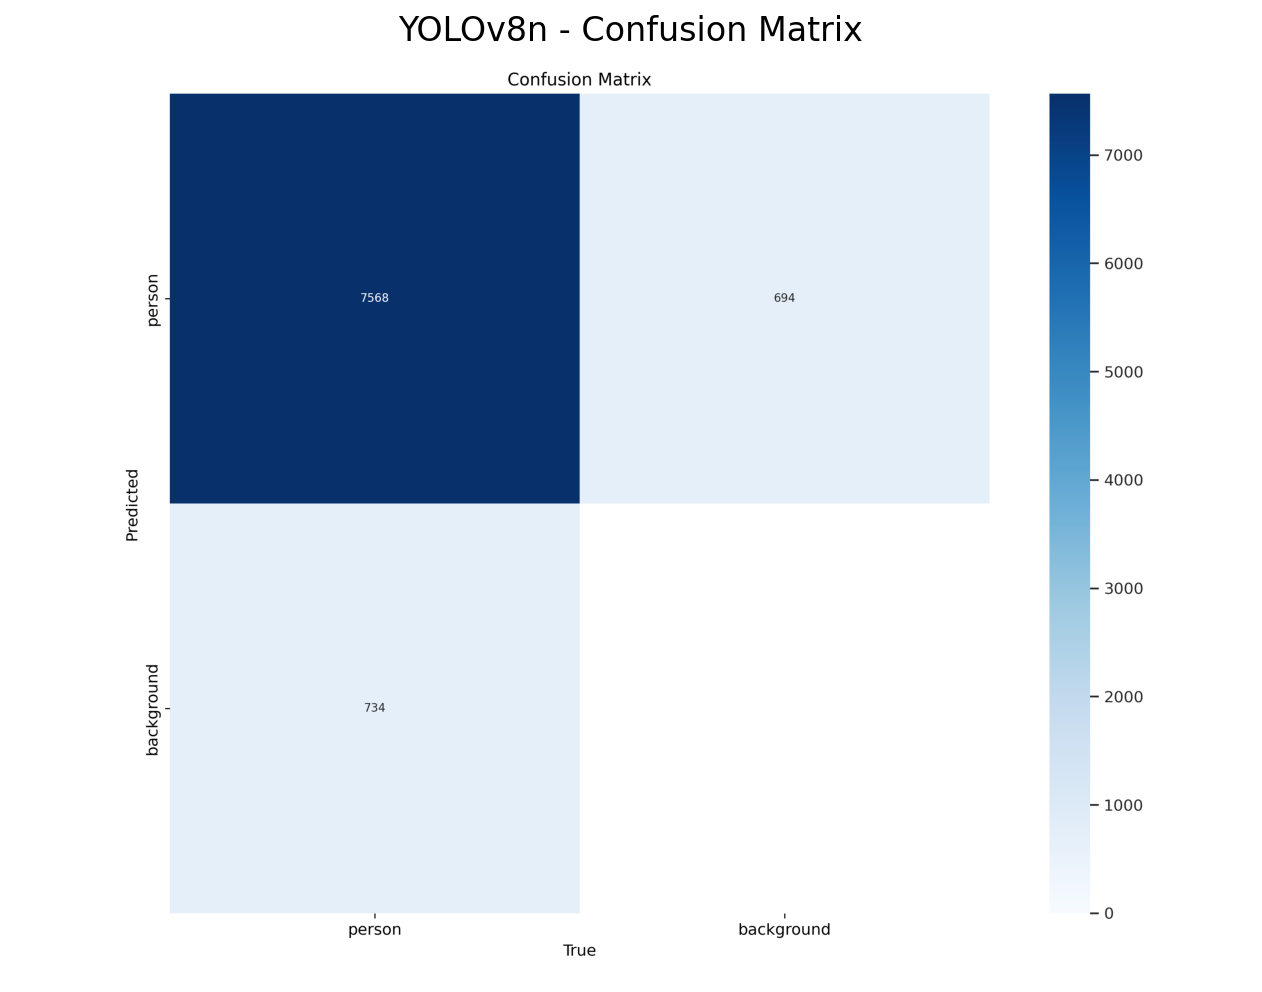

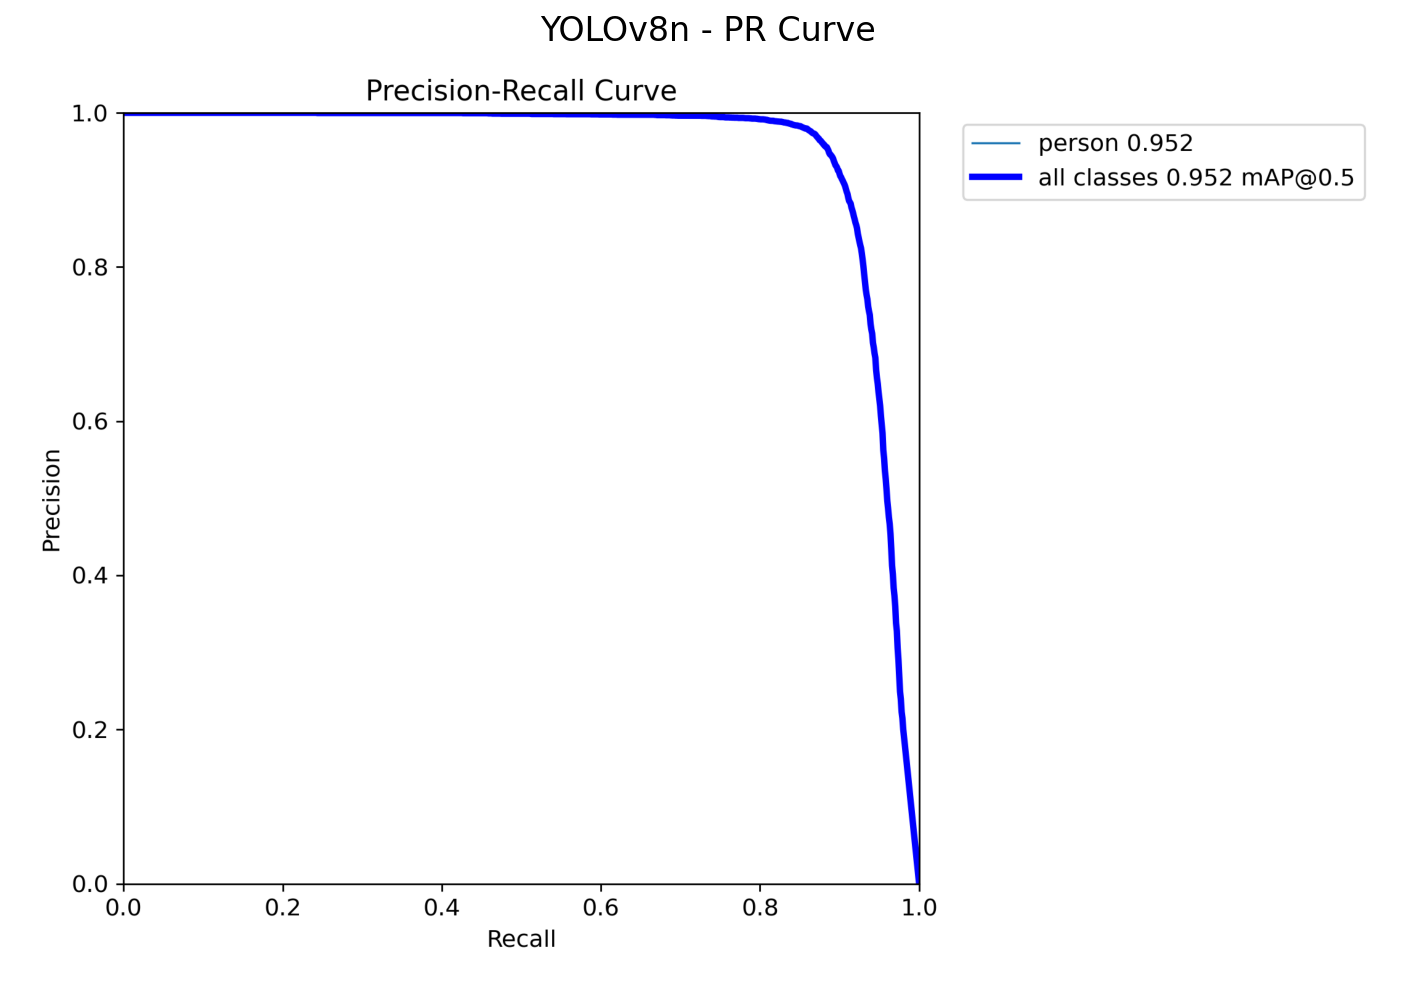

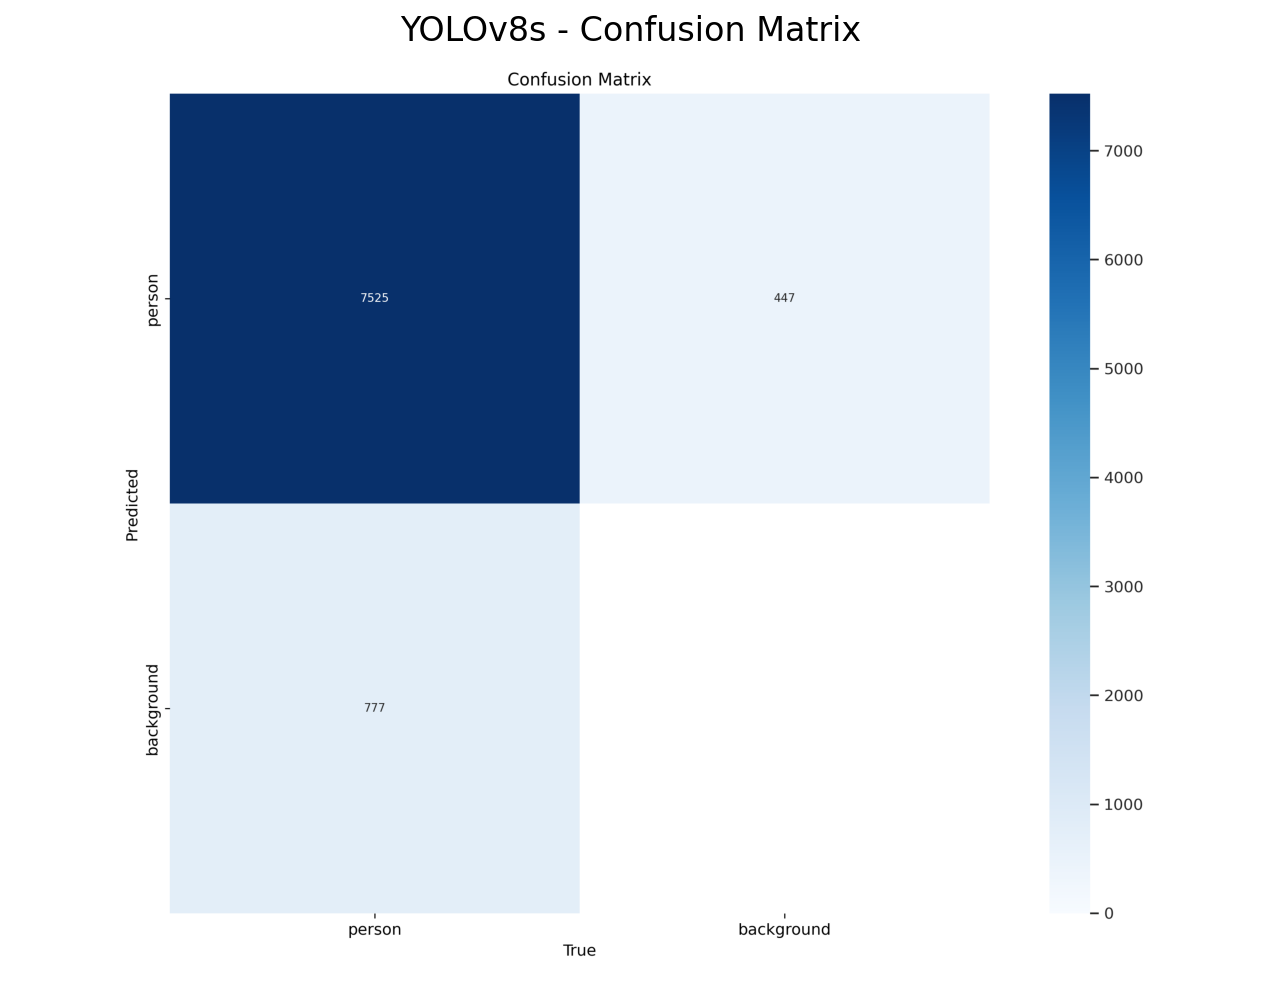

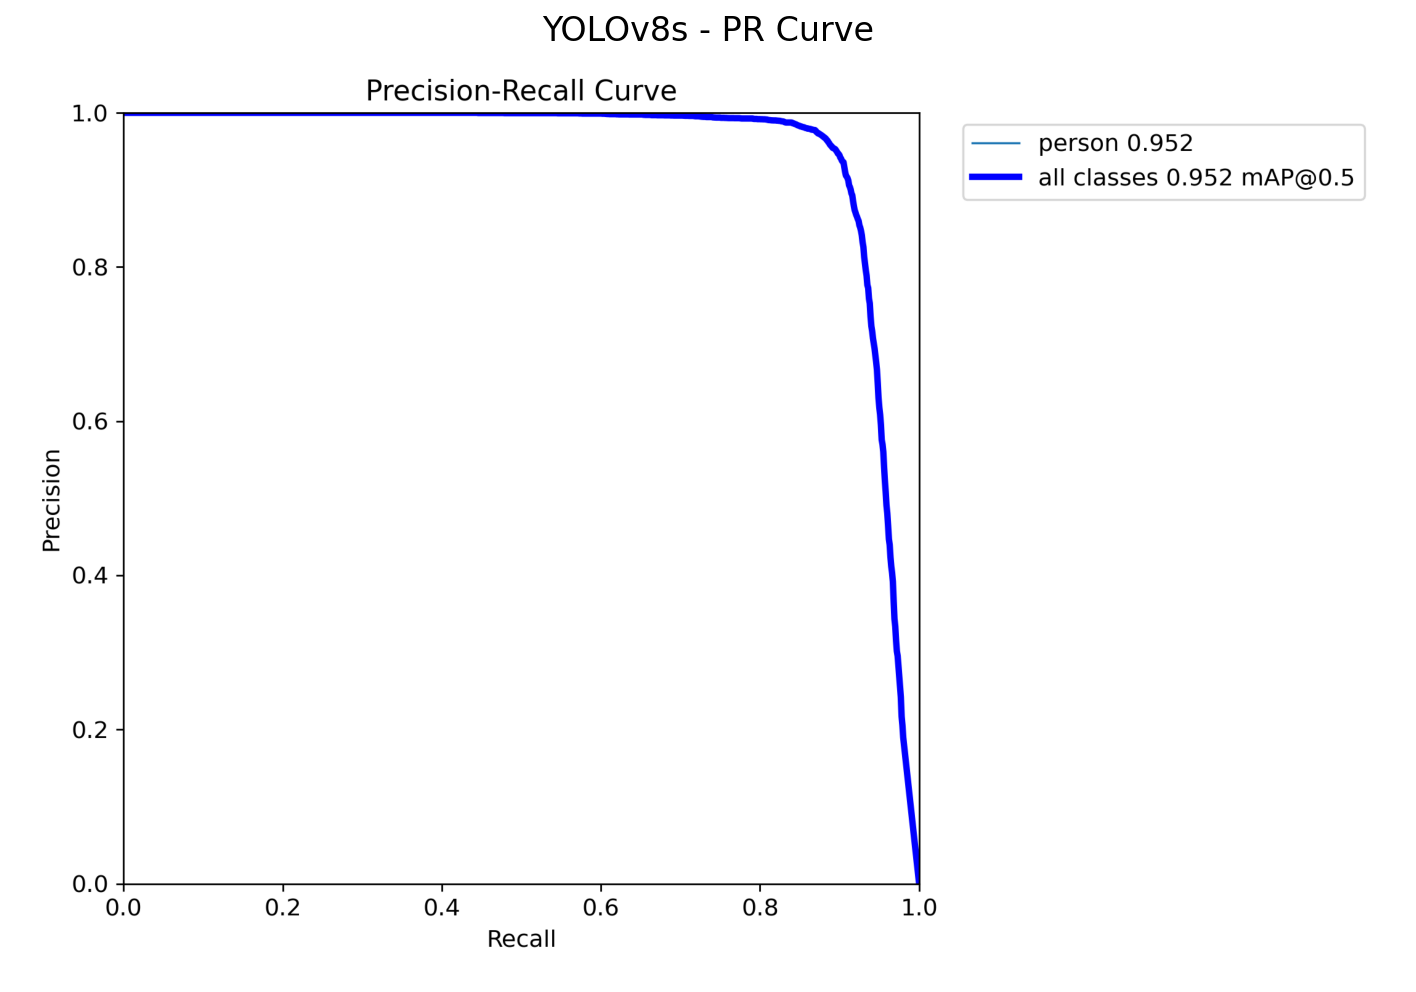

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(path, title):
    img = mpimg.imread(path)
    plt.figure(figsize=(12, 8), dpi=150)  # رفع الدقة
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# YOLOv8n
show_image("runs/yolov8_results/yolov8n_eval/confusion_matrix.png", "YOLOv8n - Confusion Matrix")
show_image("runs/yolov8_results/yolov8n_eval/PR_curve.png", "YOLOv8n - PR Curve")

# YOLOv8s
show_image("runs/yolov8_results/yolov8s_eval/confusion_matrix.png", "YOLOv8s - Confusion Matrix")
show_image("runs/yolov8_results/yolov8s_eval/PR_curve.png", "YOLOv8s - PR Curve")


# Faster R-CNN

In [ ]:
#Dataset configuration
train_img_dir = "/content/preprocessed_data/train/images"
test_img_dir = "/content/preprocessed_data/test/images"
train_ann_path = "/content/preprocessed_data/annotations/train_coco_cleaned.json"
test_ann_path = "/content/preprocessed_data/annotations/test_coco_cleaned.json"

#Convert COCO format to Faster R-CNN target format ===
def convert_target(target):
    boxes, labels = [], []
    for obj in target:
        x, y, w, h = obj['bbox']
        if w > 0 and h > 0:
            boxes.append([x, y, x + w, y + h])
            labels.append(1)  # Class ID for 'person'
    return {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    }

#Custom dataset class for COCO
class CocoFRCNNDataset(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        target = convert_target(target)
        if len(target["boxes"]) == 0:
            return self.__getitem__((idx + 1) % len(self))
        return img, target

#Collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

#Define transforms and load data
transform = T.Compose([T.ToTensor()])
train_dataset = CocoFRCNNDataset(train_img_dir, train_ann_path, transform=transform)
test_dataset = CocoFRCNNDataset(test_img_dir, test_ann_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
#Load and modify Faster R-CNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
model.to(device)

#Optimizer and scheduler
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#Training loop
train_losses = []
val_map50s = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\n Epoch [{epoch+1}/{num_epochs}]")
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss)
    lr_scheduler.step()
    print(f"Total Loss: {total_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 210MB/s]



 Epoch [1/10]


Epoch 1: 100%|██████████| 1503/1503 [07:06<00:00,  3.52it/s]


Total Loss: 384.0621

 Epoch [2/10]


Epoch 2: 100%|██████████| 1503/1503 [07:05<00:00,  3.53it/s]


Total Loss: 323.7772

 Epoch [3/10]


Epoch 3: 100%|██████████| 1503/1503 [07:04<00:00,  3.54it/s]


Total Loss: 304.4554

 Epoch [4/10]


Epoch 4: 100%|██████████| 1503/1503 [07:05<00:00,  3.53it/s]


Total Loss: 287.7514

 Epoch [5/10]


Epoch 5: 100%|██████████| 1503/1503 [07:04<00:00,  3.54it/s]


Total Loss: 286.1938

 Epoch [6/10]


Epoch 6: 100%|██████████| 1503/1503 [07:04<00:00,  3.54it/s]


Total Loss: 284.4907

 Epoch [7/10]


Epoch 7: 100%|██████████| 1503/1503 [07:04<00:00,  3.54it/s]


Total Loss: 282.7210

 Epoch [8/10]


Epoch 8: 100%|██████████| 1503/1503 [07:04<00:00,  3.54it/s]


Total Loss: 282.4694

 Epoch [9/10]


Epoch 9: 100%|██████████| 1503/1503 [07:04<00:00,  3.54it/s]


Total Loss: 282.3882

 Epoch [10/10]


Epoch 10: 100%|██████████| 1503/1503 [07:04<00:00,  3.54it/s]

Total Loss: 281.9510


In [ ]:
#Final Overall Evaluation Summary
final_metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5, 0.75, 0.5])
model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        outputs_cpu = [{k: v.cpu() for k, v in o.items()} for o in outputs]
        targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
        final_metric.update(outputs_cpu, targets_cpu)

results = final_metric.compute()
metrics_dict = eval_metric.compute()

print("📊 Faster R-CNN Evaluation Summary")
print(f"mAP@0.5: {metrics_dict['map_50']:.4f}")
print(f"mAP@[.5:.95]: {metrics_dict['map']:.4f}")
print(f"Mean Average Recall (mar_100): {metrics_dict['mar_100']:.4f}")


📊 Faster R-CNN Evaluation Summary
mAP@0.5: 0.9500
mAP@[.5:.95]: 0.9500
Mean Average Recall (mar_100): 0.9702


In [ ]:
print("Class names:", metrics_dict['classes'])
print("Per-class mAP:", metrics_dict['map_per_class'])
print("Per-class MAR:", metrics_dict['mar_100_per_class'])


Class names: tensor(1, dtype=torch.int32)
Per-class mAP: tensor(0.9500)
Per-class MAR: tensor(0.9702)


In [ ]:
def collect_pr_data(model, dataloader, device):
    model.eval()
    all_scores, all_labels = [], []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                true_labels = target['labels'].numpy()

                # For each predicted box, append score and a pseudo ground-truth label
                all_scores.extend(scores)
                all_labels.extend([1 if label in true_labels else 0 for label in pred_labels])  # Simplified match

    return all_scores, all_labels


In [ ]:
# Check alignment of prediction scores and ground truth labels
def inspect_scores_targets(scores, targets):
    print(f"Total Scores: {len(scores)}")
    print(f"Total Targets: {len(targets)}")

    if len(scores) != len(targets):
        print("Mismatch detected!")
    elif len(scores) == 0:
        print(" Lists are empty.")
    else:
        print("Scores and Targets are aligned.")
        print("First 5 Scores:", scores[:5])
        print("First 5 Targets:", targets[:5])

# Example usage after collecting them
inspect_scores_targets(scores, targets)


Total Scores: 21861
Total Targets: 21861
Scores and Targets are aligned.
First 5 Scores: [0.9981129169464111, 0.9959167838096619, 0.33067408204078674, 0.998323380947113, 0.9987363219261169]
First 5 Targets: [1, 1, 0, 1, 1]


In [ ]:
from torchvision.ops import box_iou

def collect_scores_and_targets_iou(model, dataloader, device, iou_thresh=0.5):
    model.eval()
    all_scores = []
    all_targets = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output["boxes"].cpu()
                pred_scores = output["scores"].cpu()
                pred_labels = output["labels"].cpu()

                gt_boxes = targets[i]["boxes"].cpu()
                gt_labels = targets[i]["labels"].cpu()

                if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                    continue

                ious = box_iou(pred_boxes, gt_boxes)
                max_ious, max_indices = ious.max(dim=1)

                for j, iou in enumerate(max_ious):
                    score = pred_scores[j]
                    label = pred_labels[j]

                    if label == 1:  # Only for "person"
                        all_scores.append(score.item())
                        all_targets.append(1 if iou >= iou_thresh else 0)

    return all_scores, all_targets


Total Scores: 21861
Total Targets: 21861
Scores and Targets are aligned.
First 5 Scores: [0.9981129169464111, 0.9959167838096619, 0.33067408204078674, 0.998323380947113, 0.9987363219261169]
First 5 Targets: [1, 1, 0, 1, 1]


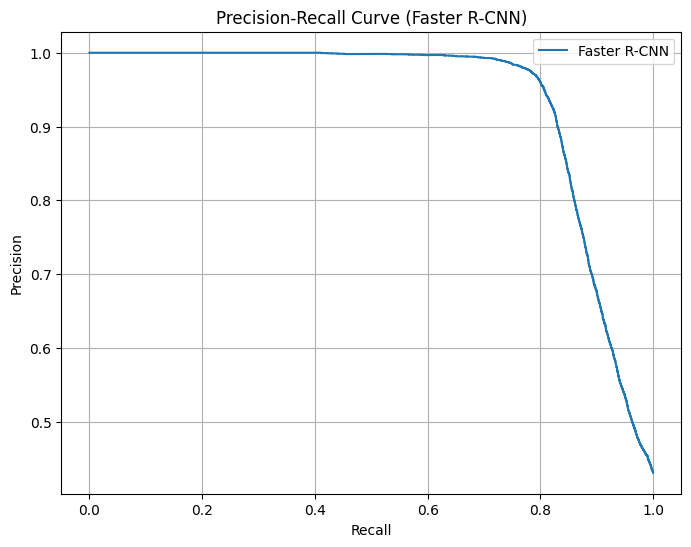

In [ ]:
scores, targets = collect_scores_and_targets_iou(model, test_loader, device)
inspect_scores_targets(scores, targets)
plot_pr_curve(scores, targets, model_name="Faster R-CNN")


# RetinaNet

In [ ]:
#Convert COCO annotation to RetinaNet format
def convert_target_retina(target):
    boxes, labels = [], []
    for obj in target:
        x, y, w, h = obj['bbox']
        if w > 0 and h > 0:
            boxes.append([x, y, x + w, y + h])
            labels.append(1)  # Class: person
    return {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    }

#Custom COCO dataset for RetinaNet
class CocoRetinaDataset(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        target = convert_target_retina(target)
        if len(target["boxes"]) == 0:
            return self.__getitem__((idx + 1) % len(self))
        return img, target

#Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

#Transforms
transform = T.Compose([T.ToTensor()])

#Load datasets
retina_train = CocoRetinaDataset(train_img_dir, train_ann_path, transform=transform)
retina_test = CocoRetinaDataset(test_img_dir, test_ann_path, transform=transform)
retina_train_loader = DataLoader(retina_train, batch_size=8, shuffle=True, collate_fn=collate_fn)
retina_test_loader = DataLoader(retina_test, batch_size=4, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
#Load pretrained RetinaNet and modify classifier
weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
model = retinanet_resnet50_fpn(weights=weights)
in_channels = model.backbone.out_channels
num_anchors = model.head.classification_head.num_anchors
model.head.classification_head = RetinaNetClassificationHead(in_channels, num_anchors, num_classes=2)
model.to(device)

#Optimizer and scheduler
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad],
                            lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

#Training
train_losses = []
val_map50s = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    for images, targets in tqdm(retina_train_loader, desc=f"Epoch {epoch+1}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss)
    lr_scheduler.step()
    print(f"Total Loss: {total_loss:.4f}")

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:02<00:00, 46.3MB/s]



Epoch [1/10]


Epoch 1: 100%|██████████| 1503/1503 [05:31<00:00,  4.53it/s]


Total Loss: 872.2134

Epoch [2/10]


Epoch 2: 100%|██████████| 1503/1503 [05:31<00:00,  4.53it/s]


Total Loss: 528.5432

Epoch [3/10]


Epoch 3: 100%|██████████| 1503/1503 [05:31<00:00,  4.54it/s]


Total Loss: 482.0988

Epoch [4/10]


Epoch 4: 100%|██████████| 1503/1503 [05:31<00:00,  4.53it/s]


Total Loss: 436.0988

Epoch [5/10]


Epoch 5: 100%|██████████| 1503/1503 [05:32<00:00,  4.52it/s]


Total Loss: 429.0640

Epoch [6/10]


Epoch 6: 100%|██████████| 1503/1503 [05:31<00:00,  4.53it/s]


Total Loss: 424.5693

Epoch [7/10]


Epoch 7: 100%|██████████| 1503/1503 [05:32<00:00,  4.52it/s]


Total Loss: 418.5130

Epoch [8/10]


Epoch 8: 100%|██████████| 1503/1503 [05:31<00:00,  4.53it/s]


Total Loss: 417.8343

Epoch [9/10]


Epoch 9: 100%|██████████| 1503/1503 [05:31<00:00,  4.53it/s]


Total Loss: 417.3026

Epoch [10/10]


Epoch 10: 100%|██████████| 1503/1503 [05:32<00:00,  4.53it/s]

Total Loss: 416.6431


In [ ]:
# Final Evaluation for RetinaNet
print("\n📊 Final Overall Evaluation (RetinaNet)")

final_metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75, 0.5])
model.eval()
all_preds, all_scores, all_targets = [], [], []

with torch.no_grad():
    for images, targets in retina_test_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        outputs_cpu = [{k: v.cpu() for k, v in o.items()} for o in outputs]
        targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
        final_metric.update(outputs_cpu, targets_cpu)

        for pred, true in zip(outputs_cpu, targets_cpu):
            if len(true['labels']) == 0:
                continue
            all_targets.extend(true['labels'].numpy())
            if 'scores' in pred and len(pred['scores']) > 0:
                all_preds.extend(pred['labels'].numpy())
                all_scores.extend(pred['scores'].numpy())
            else:
                all_preds.extend([0] * len(true['labels']))
                all_scores.extend([0] * len(true['labels']))

# Compute metrics
results = final_metric.compute()
print(f"mAP@0.5: {results['map_50']:.4f}")
print(f"mAP@0.5:0.95: {results['map']:.4f}")
print(f"Ground Truths: {len(all_targets)}")
print(f"Predictions: {len(all_preds)}")




📊 Final Overall Evaluation (RetinaNet)
mAP@0.5: 0.9488
mAP@0.5:0.95: 0.8542
Ground Truths: 8302
Predictions: 72065
